In [2]:
import sys; sys.path.append('..'); from wwa import *
from scipy.stats import spearmanr, pearsonr

month_labels = ["J","F","M","A","M","J","J","A","S","O","N","D"]

xn, xx, yn, yx = [-80.5,-79.25,8.7,9.7]

# Panama Canal drought study

**Notes from kick-off meeting**
- dry season (Jan-Apr) is irrelevant for precip - wet season (May-Dec) largely irrelevant for PET
- PET is expected to be insignificant compared to water usage - typically about 1-3mm/day in wet season, 5-8mm/day in dry season
- temperatures have increased by about 1C in this region (2C for nighttime temperatures) - no change in windspeed or direction
- use ACP core stations (50 or so) within the watershed - also include coastal stations from STRI
- El Nino has strong correlation with dry years - La Nina is less strongly linked to wet years (although variability is higher in wet years)
- over long time series there's clear evidence of a decadal oscillation - which seems to be linked to the AMO
- December precip was very low this year: maybe that would also be worth looking at? (Also May, which has more of an effect on lake levels dropping - December more important for replenishment)
&nbsp;
- an interesting follow-up question: what happens in the second half of the second year? This is when replenishment should occur

---
# Precipitation

## Seasonal cycle
- CHIRPS has a similar seasonal cycle to the ACP station data, although it misses some of the most extreme events experienced at stations
- MSWEP misses the October-November peak and also overestimates 2023 precipitation
- ACP data gives similar seasonal cycle regardless of which set of stations is used

In [7]:
# load daily time series over the region
obs = {ds : xr.open_dataset("data/pr_monthly_"+ds+".nc").pr.sel(time = slice(None, "2023")) for ds in ["chirps", "mswep", "era5", "era5land", "acp-sat", "acp-sp"]}

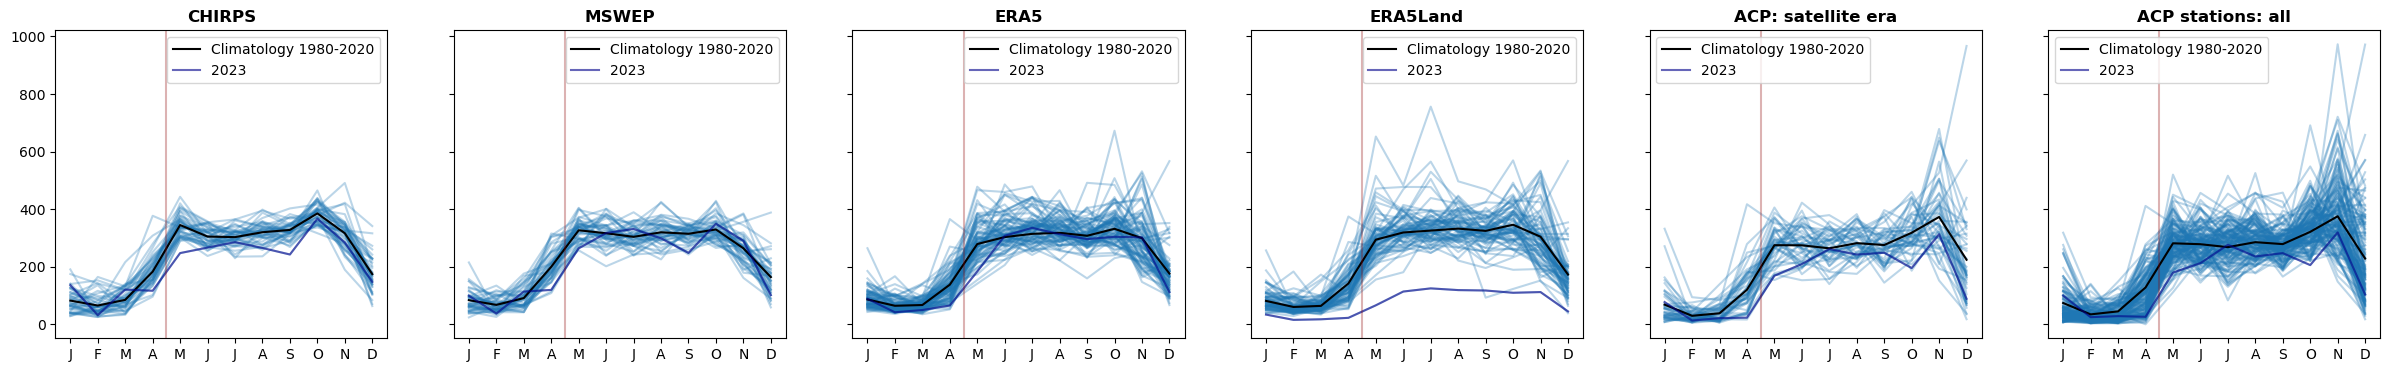

In [8]:
nobs = len(obs.keys())
fig, axs = plt.subplots(ncols = nobs, nrows = 1, figsize = (nobs*5,4), dpi = 100, sharex = True, sharey = True)

for i in range(nobs):
    ax = axs[i]
    ds = list(obs.keys())[i]
    ts = obs[ds]
    ttl = {"era5land" : "ERA5Land", "acp-sat" : "ACP: satellite era", "acp-sp" : "ACP stations: all"}

    if ds in ttl.keys():
        ttl = ttl[ds]
    else:
        ttl = ds.upper()
    
    # if ds in ["chirps", "mswep"]:
    #     ts = ts * ts.time.dt.days_in_month
        
    for y in np.unique(ts.time.dt.year.values):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.month, ts_y, color = "tab:blue", alpha = 0.3)

    ax.plot(range(1,13), ts.sel(time = slice("1980", "2020")).groupby("time.month").mean(), color = "k", label = "Climatology 1980-2020")
    ax.plot(ts_y.time.dt.month, ts_y, color = "darkblue", alpha = 0.6, label = "2023")

    ax.set_xticks(range(1,13))
    ax.set_xticklabels(month_labels)

    ax.set_title(ttl, fontweight = "bold")
    ax.legend()

    ax.axvline(4.5, color = "darkred", alpha = 0.3)
    
plt.savefig("fig/seasonal-cycle_pr_obs.png")

## Wet & dry season trends

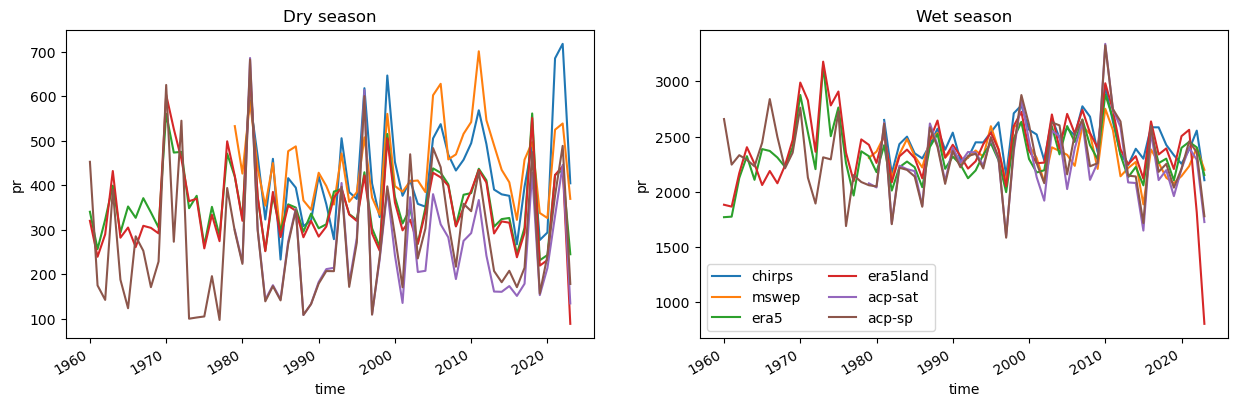

In [9]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (15,4), dpi = 100, sharex = True, sharey = False)

for ds in list(obs.keys()):
    ts = obs[ds].sel(time = slice("1960", "2023"))
    ttl = {"era5land" : "ERA5Land", "acp-sat" : "ACP: satellite era", "acp-sp" : "ACP stations: all"}
        
    ts.sel(time = [m <= 4 for m in ts.time.dt.month]).resample(time = "AS-JAN").sum().plot(ax = axs[0], label = ds)
    ts.sel(time = [m > 4 for m in ts.time.dt.month]).resample(time = "AS-JAN").sum().plot(ax = axs[1], label = ds)
    
axs[0].set_title("Dry season")
axs[1].set_title("Wet season")

# axs[0].legend(ncols = 2)
axs[1].legend(ncols = 2)

plt.savefig("fig/pr_obs.png")

## Models fitted to gridded data

In [15]:
ds = "era5land"

# load results of model fitted to gridded data
da_res = xr.open_dataset("res/res_rs_"+ds+"-gridded.nc")

# load results of model fitting per station
stn_res = merge_byindex([pd.read_csv("data/acp_stations.csv", index_col = 0)[["lon", "lat"]], 
                          pd.read_csv("res/res_rs_stations-1979-gapfilled.csv", index_col = 0).transpose()]).dropna(axis = 0, how = "any")

sf = gpd.read_file("sf_hybas06").clip((xn, xx, yn, yx))

/home/cb2714/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


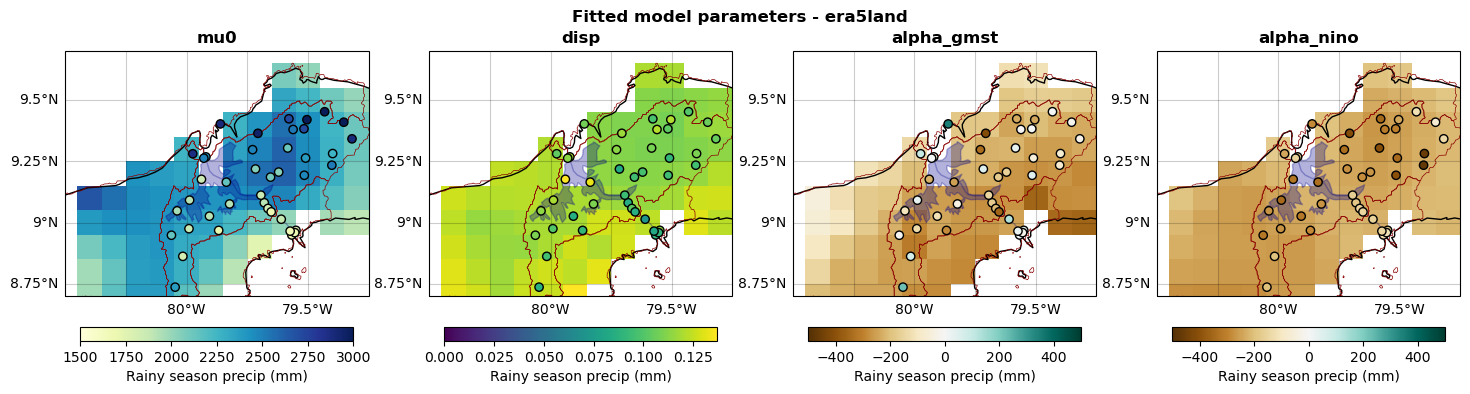

In [16]:
fig, axs = plt.subplots(ncols = 4, figsize = (18,4), dpi = 100, subplot_kw={"projection" : cartopy.crs.PlateCarree(), "extent" : [xn,xx,yn,yx]})

cbar_kwargs = {"location" : "bottom", "fraction" : 0.1, "shrink" : 0.9, "pad" : 0.1, "label" : "Rainy season precip (mm)"}

plot_kwargs = {"mu0"        : {"cmap" : "YlGnBu", "vmin" : 1500, "vmax" : 3000},
               "disp"       : {"cmap" : "viridis", "vmin" : 0},
               "alpha_gmst" : {"cmap" : "BrBG", "vmin" : -500, "vmax" : 500},
               "alpha_nino" : {"cmap" : "BrBG", "vmin" : -500, "vmax" : 500}}

# model parameters
for i in range(4):
    varnm = ["mu0", "disp", "alpha_gmst", "alpha_nino"][i]
    
    ax = axs[i]
    da_res[varnm].plot(ax = ax, cbar_kwargs = cbar_kwargs, **plot_kwargs[varnm])
    
    ax.scatter(stn_res.lon, stn_res.lat, c = stn_res[varnm], **plot_kwargs[varnm], zorder = 99, edgecolor = "k")

    ax.set_title(varnm, fontweight = "bold")
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "darkblue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left"], xlocs = np.arange(np.floor(xn),xx+0.5,0.25), ylocs = np.arange(np.floor(yn),yx+0.5,0.25))
    ax.gridlines(color = "k", alpha = 0, draw_labels = ["bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5))
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 0.5)

plt.suptitle("Fitted model parameters - "+ds, fontweight = "bold")
    
plt.savefig("fig/fitted-models-gridded_"+ds+"_model-pars.png")

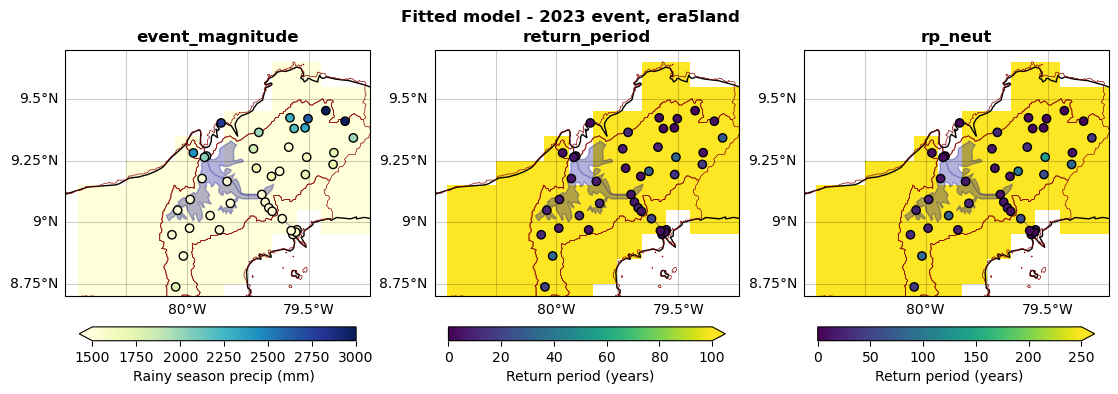

In [17]:
plot_vars = ["event_magnitude", "return_period", "rp_neut"]
var_labels = {"event_magnitude" : "Rainy season precip (mm)", "return_period" : "Return period (years)", "rp_neut" : "Return period (years)"}
n = len(plot_vars)

fig, axs = plt.subplots(ncols = n, figsize = (4.5*n,4), dpi = 100, subplot_kw={"projection" : cartopy.crs.PlateCarree(), "extent" : [xn,xx,yn,yx]})

cbar_kwargs = {"location" : "bottom", "fraction" : 0.1, "shrink" : 0.9, "pad" : 0.1}

plot_kwargs = {"event_magnitude" : {"cmap" : "YlGnBu", "vmin" : 1500, "vmax" : 3000},
               "return_period"   : {"cmap" : "viridis", "vmin" : 0, "vmax" : 100},
               "rp_neut"         : {"cmap" : "viridis", "vmin" : 0, "vmax" : 250}}

# model parameters
for i in range(n):
    varnm = plot_vars[i]
    
    ax = axs[i]
    da_res[varnm].plot(ax = ax, cbar_kwargs = cbar_kwargs | {"label" : var_labels[varnm]}, **plot_kwargs[varnm])
    ax.scatter(stn_res.lon, stn_res.lat, c = stn_res[varnm], **plot_kwargs[varnm], zorder = 99, edgecolor = "k")

    ax.set_title(varnm, fontweight = "bold")
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "darkblue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left"], xlocs = np.arange(np.floor(xn),xx+0.5,0.25), ylocs = np.arange(np.floor(yn),yx+0.5,0.25))
    ax.gridlines(color = "k", alpha = 0, draw_labels = ["bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5))
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 0.5)

plt.suptitle("Fitted model - 2023 event, "+ds, fontweight = "bold")

plt.savefig("fig/fitted-models-gridded_"+ds+"_event.png")

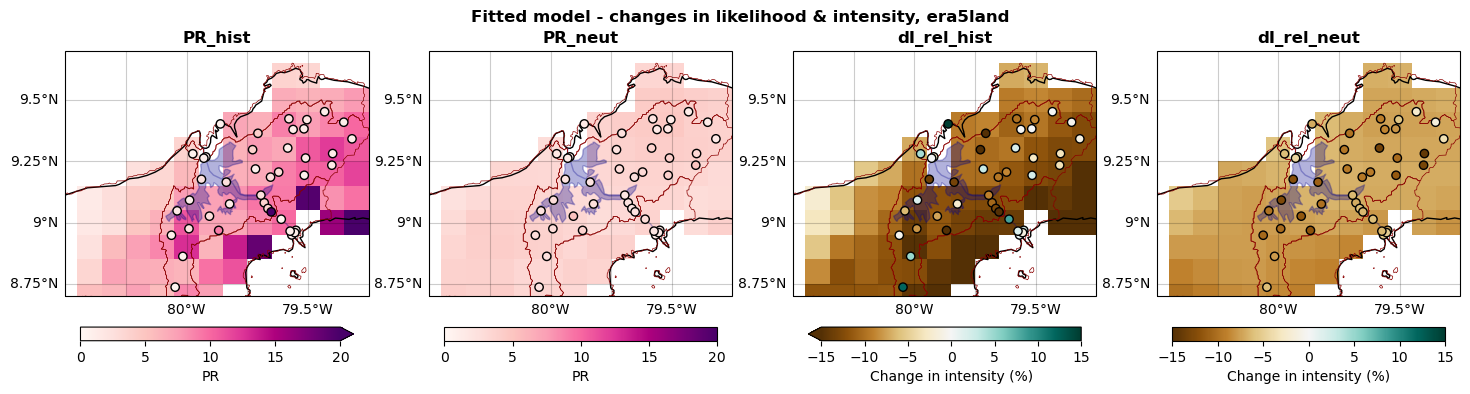

In [18]:
plot_vars = ["PR_hist", "PR_neut", "dI_rel_hist", "dI_rel_neut"]
var_labels = {"PR_hist" : "PR", "PR_neut" : "PR", "dI_rel_hist" : "Change in intensity (%)", "dI_rel_neut": "Change in intensity (%)"}
n = len(plot_vars)

fig, axs = plt.subplots(ncols = n, figsize = (4.5*n,4), dpi = 100, subplot_kw={"projection" : cartopy.crs.PlateCarree(), "extent" : [xn,xx,yn,yx]})

cbar_kwargs = {"location" : "bottom", "fraction" : 0.1, "shrink" : 0.9, "pad" : 0.1}

plot_kwargs = {"PR_hist"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 20},
               "PR_neut"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 20},
               "dI_rel_hist" : {"cmap" : "BrBG", "vmin" : -15, "vmax" : 15},
               "dI_rel_neut" : {"cmap" : "BrBG", "vmin" : -15, "vmax" : 15}}

# model parameters
for i in range(n):
    varnm = plot_vars[i]

    ax = axs[i]
    da_res[varnm].plot(ax = ax, cbar_kwargs = cbar_kwargs | {"label" : var_labels[varnm]}, **plot_kwargs[varnm])
    ax.scatter(stn_res.lon, stn_res.lat, c = stn_res[varnm], **plot_kwargs[varnm], zorder = 99, edgecolor = "k")

    ax.set_title(varnm, fontweight = "bold")
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "darkblue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left"], xlocs = np.arange(np.floor(xn),xx+0.5,0.25), ylocs = np.arange(np.floor(yn),yx+0.5,0.25))
    ax.gridlines(color = "k", alpha = 0, draw_labels = ["bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5))

    sf.boundary.plot(ax = ax, color = "darkred", lw = 0.5)

plt.suptitle("Fitted model - changes in likelihood & intensity, "+ds, fontweight = "bold")

plt.savefig("fig/fitted-models-gridded_"+ds+"_changes.png")

---
# Potential evapotranspiration

In [12]:
bci_cl = pd.read_excel("data/Evapostranspiration.xlsx", skiprows = 1, sheet_name="BCI 48m Lutz Tower", nrows = 34, index_col = "YEAR").iloc[:,:12]
bci_42 = pd.read_excel("data/Evapostranspiration.xlsx", skiprows = 48, sheet_name="BCI 48m Lutz Tower", nrows = 26, index_col = "YEAR").iloc[:,:12]
bci_48 = pd.read_excel("data/Evapostranspiration.xlsx", skiprows = 86, sheet_name="BCI 48m Lutz Tower", nrows = 18, index_col = "YEAR").iloc[:,:12]

bci_br = xr.open_dataset("data/pet_monthly_mswx-bci_br65.nc").pet
bci_hg = xr.open_dataset("data/pet_monthly_mswx-bci_hg85.nc").pet

pev_era5l = -xr.open_dataset("data/pev_monthly_era5land.nc").pev.sel(time = slice(None, "2021"))
pev_era5l = (pev_era5l * pev_era5l.time.dt.days_in_month) / 4

## Seasonal cycle

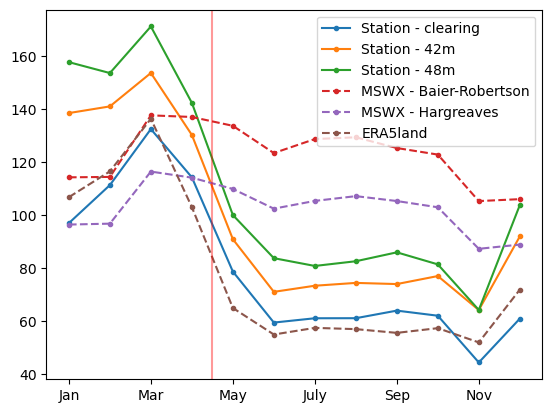

In [13]:
bci_cl.loc[slice(1994,2019)].mean(0).plot(marker = ".", label = "Station - clearing")
bci_42.loc[slice(1994,2017)].mean(0).plot(marker = ".", label = "Station - 42m")
bci_48.loc[slice(2002,2017)].mean(0).plot(marker = ".", label = "Station - 48m")

plt.gca().plot(range(12), bci_br.sel(time = slice("1994", "2019")).groupby("time.month").mean(), label = "MSWX - Baier-Robertson", marker = ".", ls = "--")
plt.gca().plot(range(12), bci_hg.sel(time = slice("1994", "2019")).groupby("time.month").mean(), label = "MSWX - Hargreaves", marker = ".", ls = "--")

plt.gca().plot(range(12), pev_era5l.sel(time = slice("1994", "2019")).groupby("time.month").mean(), label = "ERA5land", marker = ".", ls = "--")

plt.axvline(3.5, color = "red", alpha = 0.4)
plt.legend()

In [14]:
obs = {"mswx BR" : bci_br, "mswx HG" : bci_hg,
       "bci" : xr.DataArray(bci_cl.loc[slice(1994,2019)].values.flatten(), name = "pet").rename(dim_0 = "time").assign_coords(time = bci_br.sel(time = slice("1994", "2019")).time),
       "era5land" : pev_era5l}

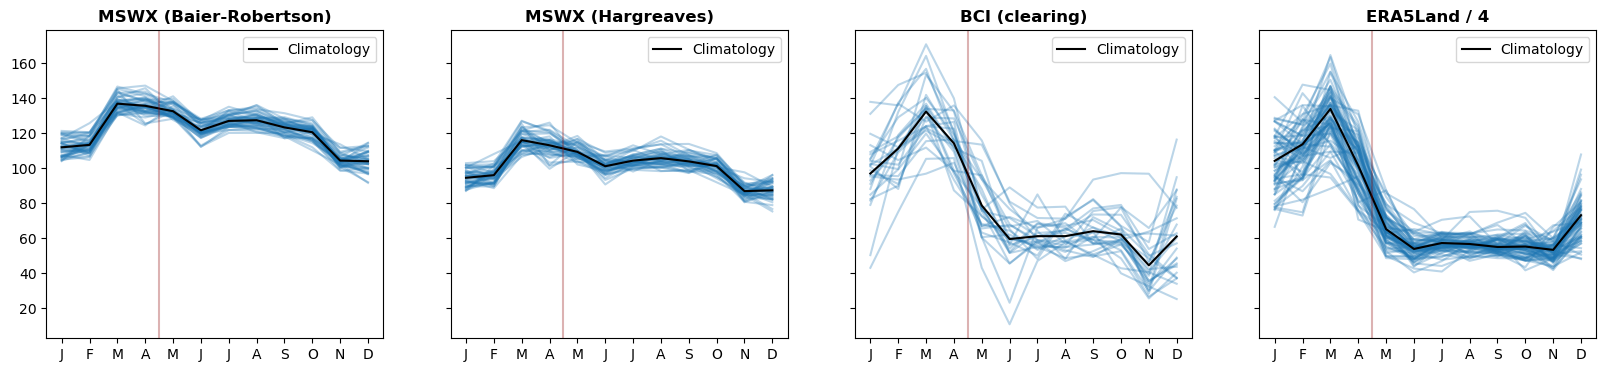

In [15]:
nobs = len(obs.keys())
fig, axs = plt.subplots(ncols = nobs, nrows = 1, figsize = (nobs*5,4), dpi = 100, sharex = True, sharey = True)

for i in range(nobs):
    ax = axs[i]
    ds = list(obs.keys())[i]
    ts = obs[ds]
    ttl = {"mswx BR" : "MSWX (Baier-Robertson)", "mswx HG" : "MSWX (Hargreaves)", "bci" : "BCI (clearing)", "era5land" : "ERA5Land / 4"}
    
    # if ds in ["chirps", "mswep"]:
    #     ts = ts * ts.time.dt.days_in_month
        
    for y in np.unique(ts.time.dt.year.values):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.month, ts_y, color = "tab:blue", alpha = 0.3)

    ax.plot(range(1,13), ts.sel(time = slice("1980", "2020")).groupby("time.month").mean(), color = "k", label = "Climatology")

    ax.set_xticks(range(1,13))
    ax.set_xticklabels(month_labels)

    ax.set_title(ttl[ds], fontweight = "bold")
    ax.legend()

    ax.axvline(4.5, color = "darkred", alpha = 0.3)
    
plt.savefig("fig/seasonal-cycle_pet_obs.png")

## Trend

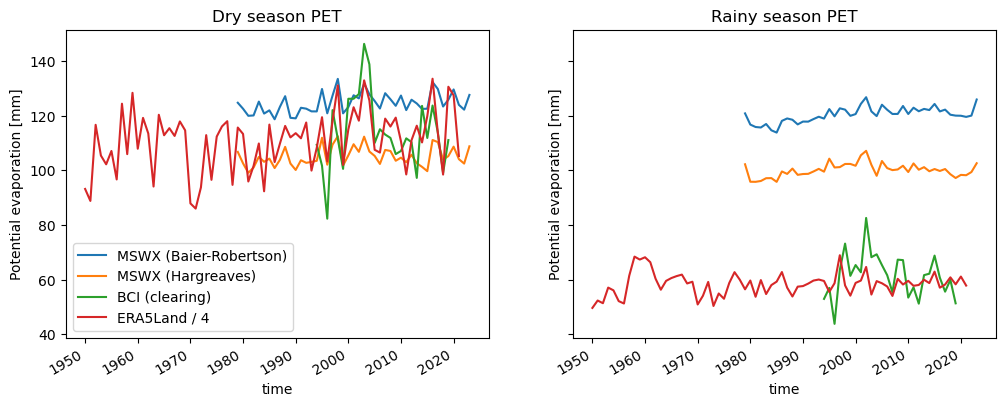

In [16]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), sharex = True, sharey = True)

for i in range(nobs):
    ds = list(obs.keys())[i]
    ts = obs[ds]
    ttl = {"mswx BR" : "MSWX (Baier-Robertson)", "mswx HG" : "MSWX (Hargreaves)", "bci" : "BCI (clearing)", "era5land" : "ERA5Land / 4"}
    
    ts.sel(time = [m <= 4 for m in ts.time.dt.month]).resample(time = "AS-JAN").mean().plot(ax = axs[0])
    ts.sel(time = [m > 4 for m in ts.time.dt.month]).resample(time = "AS-JAN").mean().plot(ax = axs[1])
    
axs[0].legend(ttl.values())
axs[0].set_title("Dry season PET")
axs[1].set_title("Rainy season PET")

plt.savefig("fig/pet_obs.png")

## Models fitted to gridded data

In [11]:
ds = "era5land"; season = "rs"; varnm = "pet"

seas_text = {"rs" : "Rainy season", "ds" : "Dry season"}[season]

# load results of model fitted to gridded data
da_res = xr.open_dataset("res/res_"+season+"_"+varnm+"_"+ds+"-gridded.nc")

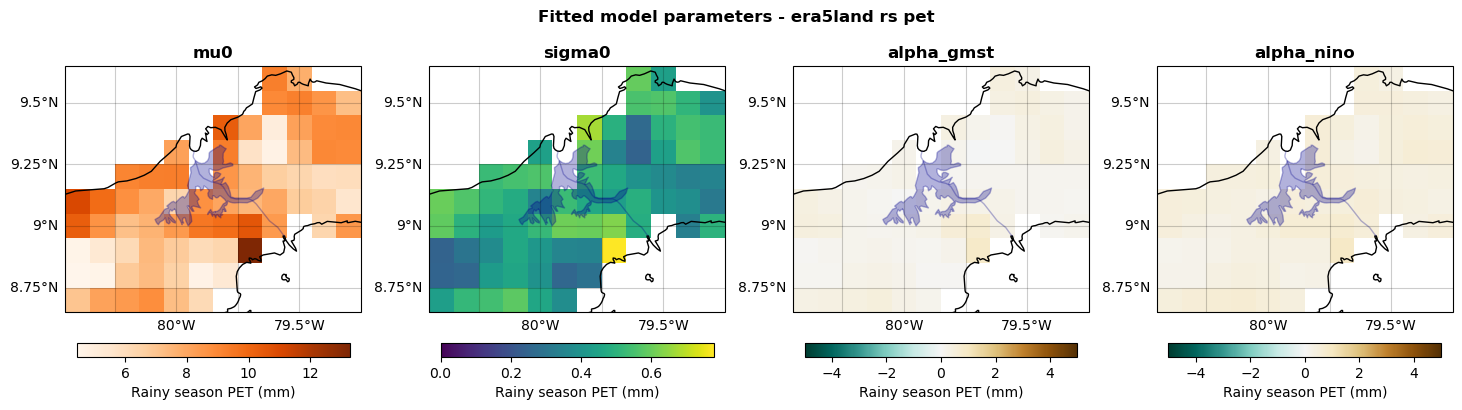

In [12]:
fig, axs = plt.subplots(ncols = 4, figsize = (18,4), dpi = 100, subplot_kw={"projection" : cartopy.crs.PlateCarree()})

cbar_kwargs = {"location" : "bottom", "fraction" : 0.1, "shrink" : 0.9, "pad" : 0.1, "label" : seas_text+" PET (mm)"}

plot_kwargs = {"mu0"        : {"cmap" : "Oranges"},
               "sigma0"     : {"cmap" : "viridis", "vmin" : 0},
               "alpha_gmst" : {"cmap" : "BrBG_r", "vmin" : -5, "vmax" : 5},
               "alpha_nino" : {"cmap" : "BrBG_r", "vmin" : -5, "vmax" : 5}}

# model parameters
for i in range(4):
    parnm = ["mu0", "sigma0", "alpha_gmst", "alpha_nino"][i]
    
    ax = axs[i]
    da_res[parnm].plot(ax = ax, cbar_kwargs = cbar_kwargs, **plot_kwargs[parnm])
    
    # ax.scatter(stn_res.lon, stn_res.lat, c = stn_res[parnm], **plot_kwargs[parnm], zorder = 99, edgecolor = "k")

    ax.set_title(parnm, fontweight = "bold")
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "darkblue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left"], xlocs = np.arange(np.floor(xn),xx+0.5,0.25), ylocs = np.arange(np.floor(yn),yx+0.5,0.25))
    ax.gridlines(color = "k", alpha = 0, draw_labels = ["bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5))

plt.suptitle("Fitted model parameters - "+ds+" "+season+" "+varnm, fontweight = "bold", y = 1.02)
    
plt.savefig("fig/fitted-models-gridded-"+varnm+"_"+season+"_"+ds+"_model-pars.png")

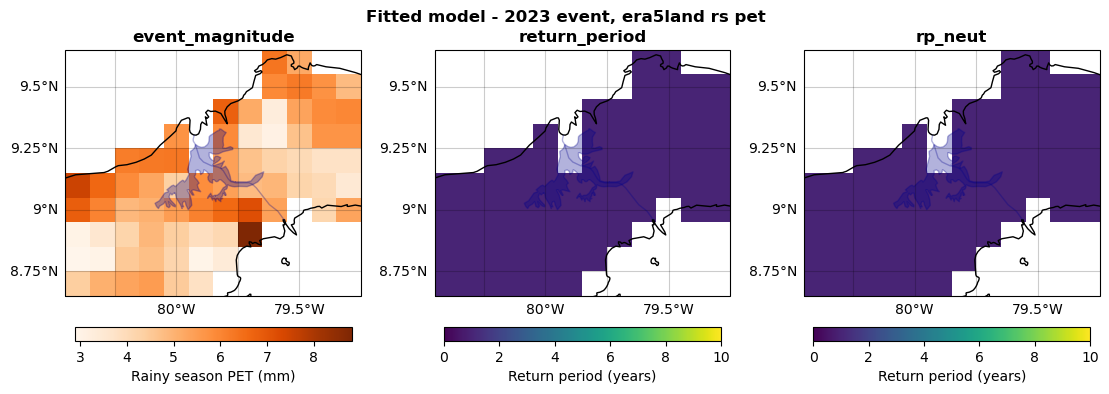

In [13]:
plot_vars = ["event_magnitude", "return_period", "rp_neut"]
var_labels = {"event_magnitude" : seas_text+" PET (mm)", "return_period" : "Return period (years)", "rp_neut" : "Return period (years)"}
n = len(plot_vars)

fig, axs = plt.subplots(ncols = n, figsize = (4.5*n,4), dpi = 100, subplot_kw={"projection" : cartopy.crs.PlateCarree()})

cbar_kwargs = {"location" : "bottom", "fraction" : 0.1, "shrink" : 0.9, "pad" : 0.1}

plot_kwargs = {"event_magnitude" : {"cmap" : "Oranges"},
               "return_period"   : {"cmap" : "viridis", "vmin" : 0, "vmax" : 10},
               "rp_neut"         : {"cmap" : "viridis", "vmin" : 0, "vmax" : 10}}

# model parameters
for i in range(n):
    parnm = plot_vars[i]
    
    ax = axs[i]
    da_res[parnm].plot(ax = ax, cbar_kwargs = cbar_kwargs | {"label" : var_labels[parnm]}, **plot_kwargs[parnm])
    # ax.scatter(stn_res.lon, stn_res.lat, c = stn_res[parnm], **plot_kwargs[parnm], zorder = 99, edgecolor = "k")

    ax.set_title(parnm, fontweight = "bold")
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "darkblue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left"], xlocs = np.arange(np.floor(xn),xx+0.5,0.25), ylocs = np.arange(np.floor(yn),yx+0.5,0.25))
    ax.gridlines(color = "k", alpha = 0, draw_labels = ["bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5))
    
plt.suptitle("Fitted model - 2023 event, "+ds+" "+season+" "+varnm, fontweight = "bold")

plt.savefig("fig/fitted-models-gridded-"+varnm+"_"+season+"_"+ds+"_event.png")

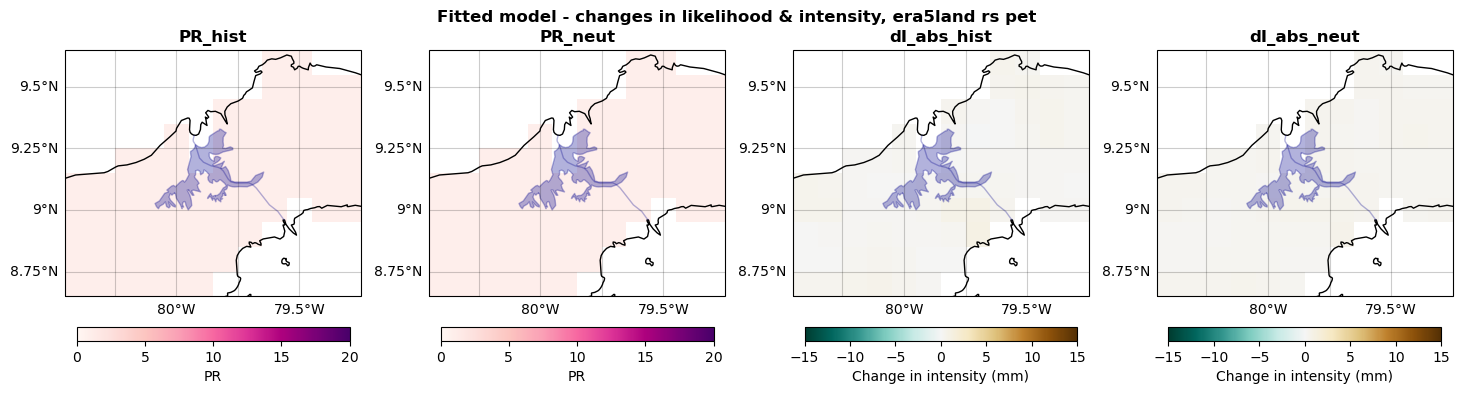

In [14]:
plot_vars = ["PR_hist", "PR_neut", "dI_abs_hist", "dI_abs_neut"]
var_labels = {"PR_hist" : "PR", "PR_neut" : "PR", "dI_abs_hist" : "Change in intensity (mm)", "dI_abs_neut": "Change in intensity (mm)"}
n = len(plot_vars)

fig, axs = plt.subplots(ncols = n, figsize = (4.5*n,4), dpi = 100, subplot_kw={"projection" : cartopy.crs.PlateCarree()})

cbar_kwargs = {"location" : "bottom", "fraction" : 0.1, "shrink" : 0.9, "pad" : 0.1}

plot_kwargs = {"PR_hist"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 20},
               "PR_neut"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 20},
               "dI_abs_hist" : {"cmap" : "BrBG_r", "vmin" : -15, "vmax" : 15},
               "dI_abs_neut" : {"cmap" : "BrBG_r", "vmin" : -15, "vmax" : 15}}

# model parameters
for i in range(n):
    parnm = plot_vars[i]

    ax = axs[i]
    da_res[parnm].plot(ax = ax, cbar_kwargs = cbar_kwargs | {"label" : var_labels[parnm]}, **plot_kwargs[parnm])
    # ax.scatter(stn_res.lon, stn_res.lat, c = stn_res[parnm], **plot_kwargs[parnm], zorder = 99, edgecolor = "k")

    ax.set_title(parnm, fontweight = "bold")
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "darkblue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left"], xlocs = np.arange(np.floor(xn),xx+0.5,0.25), ylocs = np.arange(np.floor(yn),yx+0.5,0.25))
    ax.gridlines(color = "k", alpha = 0, draw_labels = ["bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5))
    
plt.suptitle("Fitted model - changes in likelihood & intensity, "+ds+" "+season+" "+varnm, fontweight = "bold")

plt.savefig("fig/fitted-models-gridded-"+varnm+"_"+season+"_"+ds+"_changes.png")

# Temperature

## Seasonal cycle

In [40]:
bci = pd.read_csv("data/bci_monthly.csv", index_col = 0, parse_dates = [0])
bci_tg = (bci.tmax_manual + bci.tmin_manual) / 2
bci_tg = xr.DataArray(bci_tg.loc[slice("1990","2019")].values.flatten(), name = "tas").rename(dim_0 = "time").assign_coords(time = bci_tg.loc[slice("1990","2019")].index)

mswx_tg = (xr.open_dataset("data/tmax_monthly_mswx-bci.nc").tmax + xr.open_dataset("data/tmin_monthly_mswx-bci.nc").tmin) / 2

era5l = xr.open_dataset("data/tas_monthly_era5land.nc").tas.sel(time = slice(None, "2023"))
era5_tas = xr.open_dataset("data/tas_monthly_era5-05.nc").t2m.sel(time = slice(None, "2023"))

In [47]:
obs = {"MSWX (tmax+tmin)/2" : mswx_tg, "BCI (station) (tmax+tmin)/2" : bci_tg, "ERA5 tas" : era5_tas, "ERA5Land tas" : era5l}

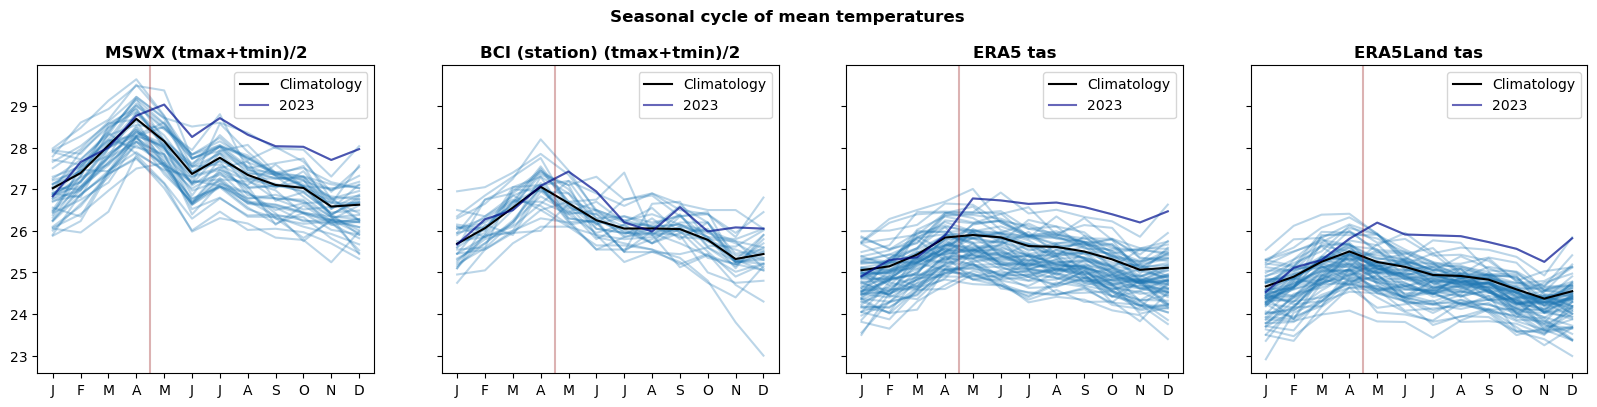

In [48]:
nobs = len(obs.keys())
fig, axs = plt.subplots(ncols = nobs, nrows = 1, figsize = (nobs*5,4), dpi = 100, sharex = True, sharey = True)

for i in range(nobs):
    ax = axs[i]
    ds = list(obs.keys())[i]
    ts = obs[ds]
        
    for y in np.unique(ts.time.dt.year.values):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.month, ts_y, color = "tab:blue", alpha = 0.3)

    ax.plot(range(1,13), ts.sel(time = slice("1990", "2020")).groupby("time.month").mean(), color = "k", label = "Climatology")
    ax.plot(ts_y.time.dt.month, ts_y, color = "darkblue", alpha = 0.6, label = "2023")

    ax.set_xticks(range(1,13))
    ax.set_xticklabels(month_labels)

    ax.set_title(ds, fontweight = "bold")
    ax.legend()

    ax.axvline(4.5, color = "darkred", alpha = 0.3)
    
plt.suptitle("Seasonal cycle of mean temperatures", fontweight = "bold", y = 1.02)
plt.savefig("fig/seasonal-cycle_tas_obs.png")

## Trend

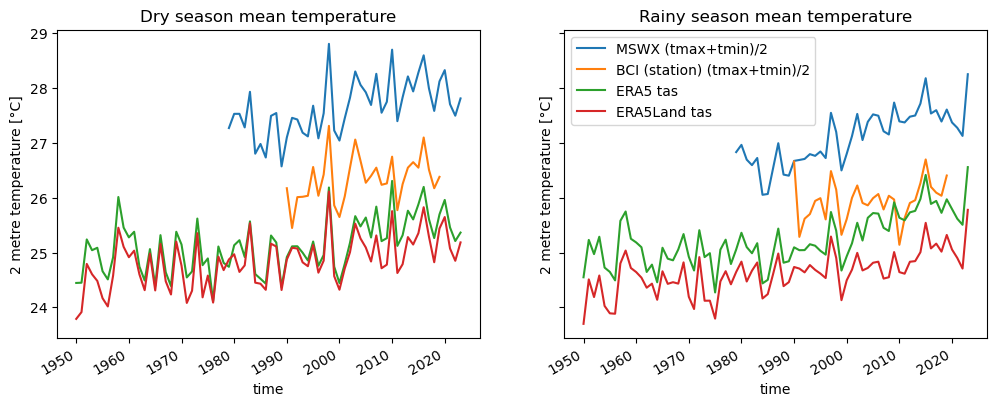

In [50]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), sharex = True, sharey = True)

for i in range(nobs):
    ds = list(obs.keys())[i]
    ts = obs[ds]
    
    ts.sel(time = [m <= 4 for m in ts.time.dt.month]).resample(time = "AS-JAN").mean().plot(ax = axs[0])
    ts.sel(time = [m > 4 for m in ts.time.dt.month]).resample(time = "AS-JAN").mean().plot(ax = axs[1])
    
axs[1].legend(list(obs.keys()))
axs[0].set_title("Dry season mean temperature")
axs[1].set_title("Rainy season mean temperature")

plt.savefig("fig/tas_obs.png")

---
# Nino3.4

## Relationship between Nino3.4 and monthly precipitation

In [3]:
# load precip & Nino time series
pr = xr.open_dataset("data/pr_monthly_acp-sp.nc").pr
nino34 = xr.open_dataset("../10_misc/detrended_nino34/ersst_nino34_detrended.nc").nino34

df = merge_byindex([pr.to_dataframe(), nino34.to_dataframe()]).dropna(axis = 0, how = "any")
df["month"] = df.index.month

In [4]:
# get correlation between Nino and precip at various lags
def lagged_corr(m, lag, nmonths, df = df):
    
    df = df.rolling(nmonths, center = False).mean()
    lcor = pd.merge(df.shift(lag).loc[df.index.month == m, "nino34"],
                    df.loc[df.index.month == m, "pr"],
                    left_index = True, right_index = True).corr().values[0,1]
    return lcor

lagged_corrs = [[lagged_corr(m, lag, 1) for m in range(1,13)] for lag in range(19)]
lagged_corrs = xr.DataArray(data = lagged_corrs, name = "corr", dims = ["lag", "month"]).assign_coords(month = range(1,13), lag = range(19))

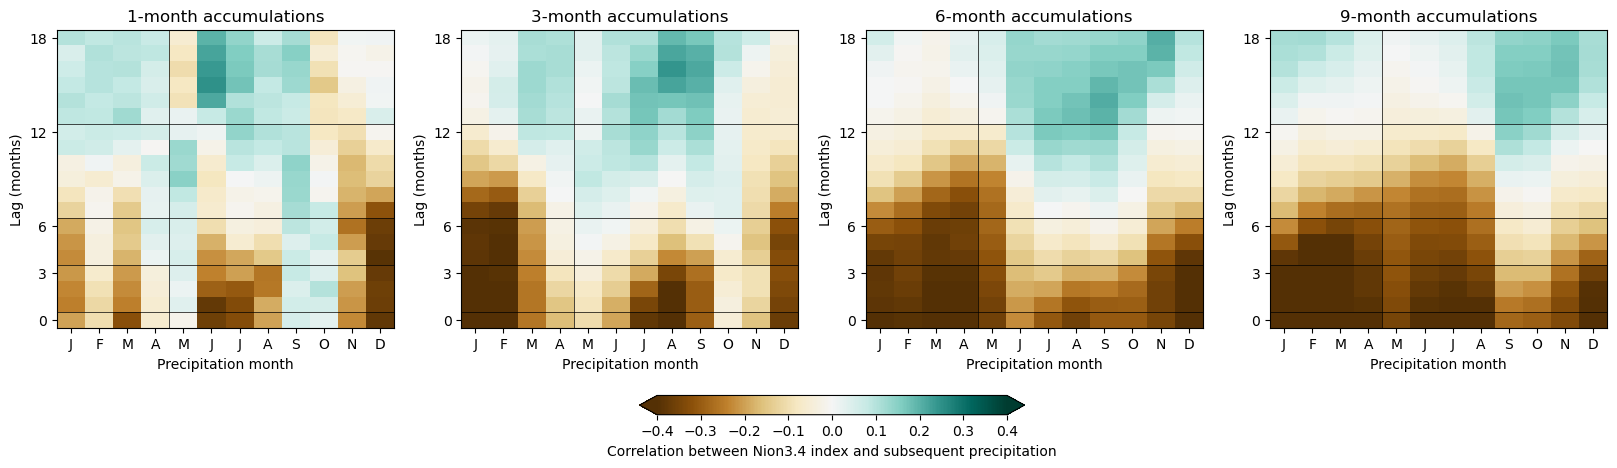

In [5]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,5), dpi = 100)
plt.subplots_adjust(wspace = 0.2)

plot_kwargs = {"cmap" : "BrBG", "vmin" : -0.4, "vmax" : 0.4}

for i in range(4):
    ax = axs[i]
    nm = [1,3,6,9][i]
    
    lagged_corrs_nm = [[lagged_corr(m, lag, nm) for m in range(1,13)] for lag in range(19)]
    lagged_corrs_nm = xr.DataArray(data = lagged_corrs_nm, name = "corr", dims = ["lag", "month"]).assign_coords(month = range(1,13), lag = range(19))

    cbar = lagged_corrs_nm.plot(ax = ax, **plot_kwargs, add_colorbar = False)
    # lagged_corrs.where(~(np.abs(lagged_corrs) < 0.1)).plot(**plot_kwargs)

    yticks = [0.5,3.5,6.5,12.5,18.5]
    [ax.axhline(y, color = "k", lw = 0.5) for y in yticks]
    ax.set_yticks([y - 0.5 for y in yticks])
    ax.set_yticklabels([int(y - 0.5) for y in yticks])

    ax.axvline(4.5, color = "k", lw = 0.5)
    ax.set_xticks(ticks = [m + 1 for m in range(12)])
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"])

    ax.set_ylabel("Lag (months)")
    ax.set_xlabel("Precipitation month")
    
    ax.set_title(str(nm)+"-month accumulations")
    
plt.colorbar(cbar, location = "bottom", ax = axs, fraction = 0.05, pad = 0.175, extend = "both", label = "Correlation between Nion3.4 index and subsequent precipitation")

# Strongest influence of Nino4.3.4 conditions seems to be on December precip, which is heavily affected by Nino3.4 up to six months previously
# Seasonally, also a strong drying effect on JJAS precip from preceding 3-6 months
# pattern is less clear for annual precip (now removed) - also some weird artefacts from crossing the wet/dry season boundary
# peak rainfall is SON: however, these months tend to be less dependent on Nino3.4
# for 8/9-month accumulation ending in December (ie for the wet season), strongest correlation with Nino at 0-3 months

In [6]:
# what about correlation with rainy season specifically?
def rs_corr(lag, nmonths, df = df):
    
    # always looking at rainy-season precip
    rs = df.rolling(8, center = False).mean()
    
    df = df.rolling(nmonths, center = False).mean()
    lcor = pd.merge(df.shift(lag).loc[df.index.month == 12, "nino34"],
                    rs.loc[rs.index.month == 12, "pr"],
                    left_index = True, right_index = True).corr().values[0,1]
    return lcor

In [7]:
lags = range(19); accums = range(1,19)
rs_corrs = [[rs_corr(lag, nm) for nm in accums] for lag in lags]
rs_corrs = xr.DataArray(data = rs_corrs, name = "corr", dims = ["lag", "nmonths"]).assign_coords(nmonths = accums, lag = lags)

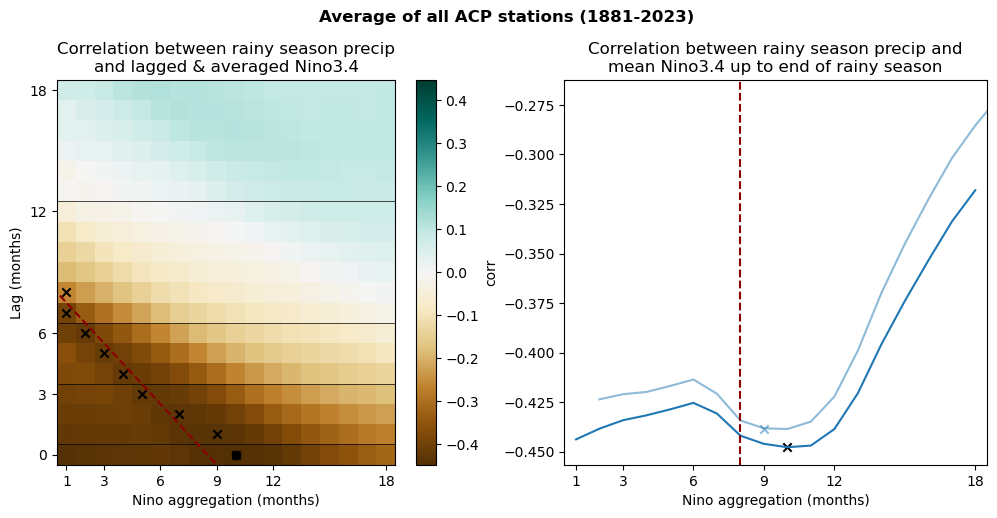

In [70]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,5), dpi = 100, sharex = True)

ax = axs[0]
rs_corrs.plot(ax = ax, cmap = "BrBG")

yticks = [0.5,3.5,6.5,12.5,18.5]
[ax.axhline(y, color = "k", lw = 0.5) for y in yticks]
ax.set_yticks([y - 0.5 for y in yticks])
ax.set_yticklabels([int(y - 0.5) for y in yticks])

x = [1,3,6,9,12,18]
ax.set_xticks(x)
ax.set_xticklabels(x)

ax.set_ylabel("Lag (months)")
ax.set_xlabel("Nino aggregation (months)")

# plot single lowest value - but don't think this is really necessary
ax.scatter(rs_corrs.idxmin("nmonths").where(rs_corrs.min("nmonths") < -0.2), lags, color = "k", marker = "x")
ax.plot((0.25,9.25), (8.25,-0.75), color = "darkred", ls = "--")

# single strongest correlation is at zero lags, with 10-month Nino
min_corr = rs_corrs.where(rs_corrs == rs_corrs.min()).dropna("lag", "all").dropna("nmonths", "all")
ax.scatter(min_corr.nmonths, min_corr.lag, marker = "o", color = "k")

ax.set_title("Correlation between rainy season precip\nand lagged & averaged Nino3.4")

ax = axs[1]
ax.plot(accums, rs_corrs.sel(lag = 0))
ax.plot([a+1 for a in accums], rs_corrs.sel(lag = 1), color = "tab:blue", alpha = 0.5)
ax.scatter(rs_corrs.sel(lag = 1).idxmin(), rs_corrs.sel(lag = 1).min(), marker = "x", color = "tab:blue", alpha = 0.5)

ax.set_xlabel("Nino aggregation (months)")
ax.set_title("Correlation between rainy season precip and\nmean Nino3.4 up to end of rainy season")
ax.axvline(8, color = "darkred", ls = "--")
ax.scatter(rs_corrs.sel(lag = 0).idxmin(), rs_corrs.sel(lag = 0).min(), marker = "x", color = "k")

plt.suptitle("Average of all ACP stations (1881-2023)", y = 1.02, fontweight = "bold")
plt.savefig("fig/nino34-correlation.png")
# for current rainy season, Nino accumulations up to 1yr previously are important
# highest correlation is with 10-month accumulation (so, rainy season plus two months preceding)
# recent months are more important - if we look at Nino conditions terminating 6 months ago, only the most recent months are relevant

In [72]:
# check that I'm correctly converting between lags/accumulations and actual time periods
print(rs_corrs.sel(lag = 6, nmonths = 2).values)

nino = df.rolling(2).mean().loc[df.index.month == 6, "nino34"].dropna(axis = 0, how = "any")
rs = df.rolling(8).sum().loc[df.index.month == 12, "pr"].dropna(axis = 0, how = "any")
print(pearsonr(rs.values, nino.values)[0])

-0.41705760036544776
-0.4170576003654483
